In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import uniform, norm
from glob import glob
from os.path import join, abspath
from os import pardir
import sys
import vaex
import os
import emcee
from multiprocessing import Pool
import time
import corner
import tqdm

# Utils functions

In [ ]:
def plot_chain(samples, labels, figsize=(10, 7), alpha=0.3, start=0):
    num = len(labels)
    fig, axes = plt.subplots(num, figsize=figsize, sharex=True)
    if len(labels) == 1:
      axes = [axes]
    for i in range(num):
        ax = axes[i]
        ax.plot(samples[start:, :, i], "k", alpha=alpha)
        ax.set_xlim(0, len(samples[start:, :, i]))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number")

In [2]:
# import utils
root_dir = abspath(pardir)
root_dir

'/home2/s20321005/Thesis-Project'

In [3]:
if root_dir not in sys.path:
    sys.path.append(root_dir)
sys.path

['/home2/s20321005/Thesis-Project/4_Gravity',
 '/home2/s20321005/.conda/envs/vaex/lib/python38.zip',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/lib-dynload',
 '',
 '/home2/s20321005/.local/lib/python3.8/site-packages',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages',
 '/home2/s20321005/Thesis-Project']

In [59]:
from utils import nu_mod, fw, safe_mkdir

In [5]:
root_data_dir = abspath(join(root_dir, "Data"))
root_data_dir

'/home2/s20321005/Thesis-Project/Data'

In [6]:
data_baryon_dir = join(root_data_dir, "Baryon")
data_velocity_dir = join(root_data_dir, "Velocity-Distribution")
data_eff_dir = join(root_data_dir, "Effective-Volume")

In [7]:
# load baryons components
df_baryon = vaex.open(join(data_baryon_dir, "baryon.hdf5"))
df_baryon

#,components,rho,e_rho,sigma_z,e_sigma_z
0,Molecular gas (H2),0.0104,0.00312,3.7,0.2
1,Cold atomic gas (HI(1)),0.0277,0.00554,7.1,0.5
2,Warm atomic gas (HI(2)),0.0073,0.0007,22.1,2.4
3,Hot ionized gas (HII),0.0005,3e-05,39.0,4.0
4,Giant stars,0.0006,6e-05,15.5,1.6
...,...,...,...,...,...
7,4 < MV < 5,0.0029,0.00029,18.0,1.8
8,5 < MV < 8,0.0072,0.00072,18.5,1.9
9,MV > 8,0.0216,0.0028,18.5,4.0
10,White dwarfs,0.0056,0.001,20.0,5.0


# Math

let $Z=\{z_i\}$ is a collection of vertical positions of the stars, and $W=\{w_i\}$ is a collection of vertical velocities of the stars. We assume that the vertical positions and velocities are independent. $Z$ and $W$ are inhomogeneous Poisson processes with intensity $\lambda(z)$ and $\mu(w)$ respectively. The intensity $\lambda(z)$ is the number density of star in vertical direction, and $\mu(w)$ is the number density of stars at some velocity $w$.

From previous notebook, the intensity $\lambda(z)$ can be calculated depent on the following parameters $\theta$:
* $\rho_{i}$ - the density of the baryons
* $\sigma_{z,i}$ - baryons velocity dispersion in vertical direction
* $\rho_{\text{DM}}$ - the density of the dark matter halo in the vicinity of the sun
* $\Sigma_{\text{DD}}$ - surface density of dark disk
* $h_{\text{DD}}$ - the vertical scale height of dark disk
* $\nu_0$ - the number density of stars in the midplane disk
* $z_{\odot}$ - the position of the sun
* $R$ - Oort constant radial contribution
* $\sigma_w$ - the velocity dispersion of the stars in vertical direction
* $w_0$ - the velocity of the sun

So,
\begin{aligned}
  \lambda (z) &= f(z;\theta) \\
  &= \nu(z;\theta) \mathcal{F} (z) \\
  &= \nu_0 \exp \left[ -\frac{\Phi(z+z_{\odot};\rho_i,\sigma_{z,i}, \rho_{\text{DM}}, \Sigma_{\text{DD}}, h_{\text{DD}}, R )}{\sigma_w^2} \right] \mathcal{F} (z)\\
\end{aligned}

Where $\mathcal{F} (z)$ is the completeness function

and the same goes for the intensity $\mu(w)$:
\begin{aligned}
  \mu (w) &= g(w;\theta) \\
  &= N_0\mathcal{N}(w;\sigma_w, w_0)
\end{aligned}

Where $N_0$ is the normalization constant

# Framework

by using Bayesian Statistics, we can calculate the posterior distribution of the parameters $\theta$ given the data $Z$ and $W$:
\begin{aligned}
  p_\text{pos}(\theta|Z,W) &= \frac{p_\text{like}(Z,W|\theta)p_\text{prior}(\theta)}{p_\text{ev}(Z,W)} \\
  &\propto p_\text{like,Z}(Z|\theta)p_\text{like,W}(W|\theta) p_0(\theta) \\
  &\propto \mathcal{L}_z(Z|\theta)\mathcal{L}_w(W|\theta) p_0(\theta) \\
  \text{log } p_\text{pos}(\theta|Z,W) &= \text{log } \mathcal{L}_z(Z|\theta) + \text{log } \mathcal{L}_w(W|\theta) + \text{log } p_0(\theta) + C\\
\end{aligned}

Where the likelihood is the likelihood of inhomogeneous Poisson process,
\begin{aligned}
  \text{log } \mathcal{L}_z(Z|\theta) &= \sum_i \log \lambda(z_i) - \int \lambda(z) \text{ d}z \\
  \text{log } \mathcal{L}_w(W|\theta) &= \sum_i \log \mu(w_i) - \int \mu(w) \text{ d}w \\
\end{aligned}

### Prior

Either we can use a uniform prior or a Gaussian prior. The uniform prior is represented by [lower, upper].
| Parameter | Prior | Description |
| --- | --- | --- |
| $\rho_{i}$ | Gaussian | Check the baryons table |
| $\sigma_{z,i}$ | Gaussian | Check the baryons table |
| $\rho_{\text{DM}}$ | [0, 0.06] msun/pc^3 |  |
| $\Sigma_{\text{DD}}$ | [0, 30] msun/pc^2 | |
| $h_{\text{DD}}$ | [0, 100] pc |  |
| $\text{log }\nu_0$ | [12, 13] | A star (star/kpc^3) |
|  | [14, 14.4] | F star |
|  | [13.8, 14] | G star |
| $z_{\odot}$ | [-50, 50] pc | |
| $R$ | Gaussian | mean=3.4E-3, std=0.6E-3 in msun/pc^3|
| $\sigma_w$ | [1, 20] km/s | |
| $w_0$ | [-20, 20] km/s | |

In [8]:
number_files = glob(join(data_eff_dir, "*.hdf5"))
number_files.sort()
number_files

['/home2/s20321005/Thesis-Project/Data/Effective-Volume/gaia_(-0.10)_(0.19).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume/gaia_(0.19)_(0.25).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume/gaia_(0.25)_(0.30).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume/gaia_(0.30)_(0.34).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume/gaia_(0.34)_(0.37).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume/gaia_(0.37)_(0.40).hdf5']

In [9]:
index = 0
df_number = vaex.open(number_files[index])
df_number

#,z,density_corr,density,density_err
0,-189.4736842105263,5.0102322339836605e-06,3.678247573679359e-06,4.912936909368127e-07
1,-168.42105263157896,5.769611755526935e-06,4.208764050652343e-06,5.288994424727842e-07
2,-147.36842105263156,7.662445449505041e-06,5.55273912565057e-06,6.115297216198587e-07
3,-126.3157894736842,1.0416962868488793e-05,7.497966207884847e-06,7.15439947124087e-07
4,-105.26315789473684,1.4594550822695601e-05,1.0433490713802027e-05,8.497276008511714e-07
...,...,...,...,...
14,105.26315789473685,1.434718555451432e-05,1.0256651888144366e-05,8.424957450740081e-07
15,126.31578947368422,1.0515236103097178e-05,7.568701738147911e-06,7.188067419418892e-07
16,147.36842105263162,8.248110069849377e-06,5.977152307228958e-06,6.344700053730289e-07
17,168.421052631579,6.205968947121409e-06,4.527073936836134e-06,5.485353407928359e-07


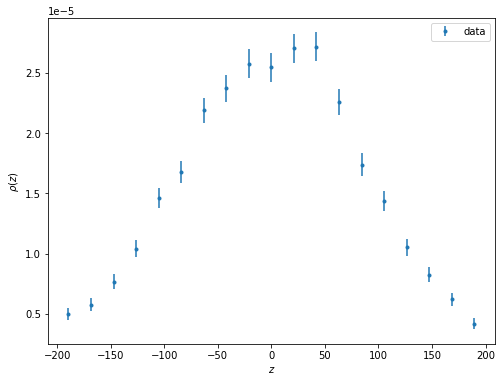

In [23]:
zdens = df_number['density_corr'].to_numpy()
zerr = df_number['density_err'].to_numpy()
zmid = df_number['z'].to_numpy()

# plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(zmid, zdens, yerr=zerr, fmt='.', label='data')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\rho(z)$')
ax.legend()
plt.show()

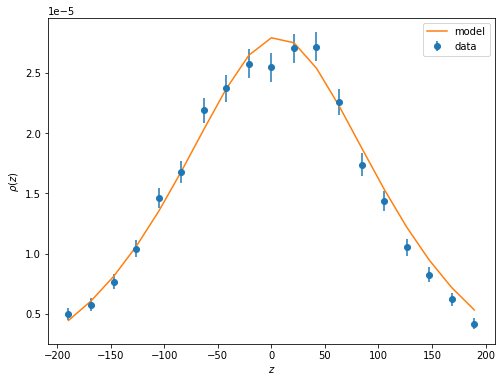

In [24]:
rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s

e_rhos = df_baryon["e_rho"].to_numpy()  # Msun/pc^3
e_sigmaz = df_baryon["e_sigma_z"].to_numpy() # km/s

# test the following dark values
rhoDM = 0.016 # Msun/pc^3
sigmaDD = 7 # Msun/pc^2
hDD = 20 # pc
R = 3.4E-3 # Msun/pc^3
nu0 = 2.8E-5
zsun = -6

theta_dict = dict(
    rhos=rhos, 
    sigmaz=sigmaz, 
    rhoDM=rhoDM, 
    sigmaDD=sigmaDD, 
    hDD=hDD, 
    nu0=nu0, 
    zsun=zsun, 
    R=R,
    sigma_w=np.array([8]),
    w0=np.array([-7]),
    a=np.array([1])
)

nu = nu_mod(zmid, **theta_dict)

fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(zmid, zdens, yerr=zerr, fmt='o', label='data')
ax.plot(zmid, nu, label='model')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\rho(z)$')
ax.legend()
plt.show()

In [12]:
velocity_files = glob(join(data_velocity_dir, "gaia_*.hdf5"))
velocity_files.sort()
velocity_files

['/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/gaia_(-0.10)_(0.19).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/gaia_(0.19)_(0.25).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/gaia_(0.25)_(0.30).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/gaia_(0.30)_(0.34).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/gaia_(0.34)_(0.37).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/gaia_(0.37)_(0.40).hdf5']

In [13]:
velocity_popt_files = glob(join(data_velocity_dir, "popt_gaia_*.hdf5"))
velocity_popt_files.sort()
velocity_popt_files

['/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/popt_gaia_(-0.10)_(0.19).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/popt_gaia_(0.19)_(0.25).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/popt_gaia_(0.25)_(0.30).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/popt_gaia_(0.30)_(0.34).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/popt_gaia_(0.34)_(0.37).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/popt_gaia_(0.37)_(0.40).hdf5']

In [14]:
df_velocity = vaex.open(velocity_files[index])
df_velocity

#,w,wnum,werr
0,-67.58620689655172,8.05376582981559e-05,5.6948724323511066e-05
1,-62.758620689655174,4.026882914907795e-05,4.026882914907795e-05
2,-53.10344827586207,4.026882914907795e-05,4.026882914907795e-05
3,-48.275862068965516,8.05376582981559e-05,5.6948724323511066e-05
4,-38.62068965517241,0.00024161297489446772,9.863808395455469e-05
...,...,...,...
17,24.137931034482754,0.0001610753165963118,8.05376582981559e-05
18,28.96551724137931,0.00012080648744723386,6.974765804751361e-05
19,33.79310344827586,8.05376582981559e-05,5.6948724323511066e-05
20,38.620689655172406,0.0001610753165963118,8.05376582981559e-05


In [15]:
df_popt = vaex.open(velocity_popt_files[index])
popt = df_popt['popt'].to_numpy()
popt

array([ 0.07941616, -6.3139583 ,  2.75078696,  0.91130269, -7.25885714,
        7.87732938])

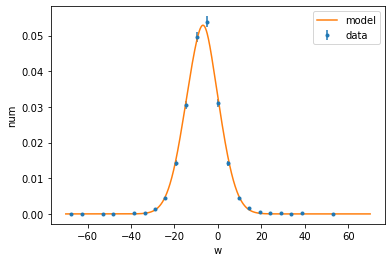

In [26]:
wdens= df_velocity['wnum'].to_numpy()
werr = df_velocity['werr'].to_numpy()
wmid = df_velocity['w'].to_numpy()

w0 = []
sigma_w = []
a_raw = []

for i in range(len(popt)//3):
    w0_i = popt[3*i+1]
    sigma_w_i = popt[3*i+2]
    a_raw_i = popt[3*i]
    
    w0.append(w0_i)
    sigma_w.append(sigma_w_i)
    a_raw.append(a_raw_i)

w0 = np.array(w0)
sigma_w = np.array(sigma_w)
a_raw = np.array(a_raw)

theta = dict(
    rhos=rhos, 
    sigmaz=sigmaz, 
    rhoDM=rhoDM, 
    sigmaDD=sigmaDD, 
    hDD=hDD, 
    nu0=nu0, 
    zsun=zsun, 
    R=R, 
    w0=w0, 
    sigma_w=sigma_w, 
    a=a_raw
)

ws = np.linspace(-70, 70, 1000)
Fw = fw(ws, **theta)

# plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(wmid, wdens, yerr=werr, fmt='.', label='data')
ax.plot(ws, Fw, label='model')
ax.set_xlabel(r'w')
ax.set_ylabel(r'num')
ax.legend()
plt.show()

In [17]:
args = ('rhos', 'sigmaz', 'rhoDM', 'sigmaDD', 'hDD', 'nu0', 'zsun', 'R', 'sigma_w', 'w0', 'a')

args_loc = tuple(item+"_loc" for item in args)
args_loc

('rhos_loc',
 'sigmaz_loc',
 'rhoDM_loc',
 'sigmaDD_loc',
 'hDD_loc',
 'nu0_loc',
 'zsun_loc',
 'R_loc',
 'sigma_w_loc',
 'w0_loc',
 'a_loc')

In [18]:
uni_list = ['log_rhoDM', 'log_sigmaDD', 'log_hDD', 'log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a']
norm_list = ['rhos', 'sigmaz', 'R']
args = tuple(norm_list+uni_list)
args

('rhos',
 'sigmaz',
 'R',
 'log_rhoDM',
 'log_sigmaDD',
 'log_hDD',
 'log_nu0',
 'zsun',
 'log_sigma_w',
 'w0',
 'a')

In [230]:
uni_list = ['log_rhoDM', 'log_sigmaDD', 'log_hDD', 'log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a']
norm_list = ['rhos', 'sigmaz', 'R']
def log_prior(theta, locs, scales, norm_list, uni_list):
    pars_list = norm_list+uni_list
    result = 0
    for item in pars_list:
        if item in uni_list:
            result += np.sum(uniform.logpdf(theta[item], loc=locs[item], scale=scales[item]))
        elif item in norm_list:
            result += np.sum(norm.logpdf(theta[item], loc=locs[item], scale=scales[item]))
    return result

In [117]:
locs = dict(
    rhos=rhos, 
    sigmaz=sigmaz, 
    log_rhoDM=np.log(0.005), 
    log_sigmaDD=np.log(1), 
    log_hDD=np.log(1), 
    log_nu0=np.log(1E-5), 
    zsun=-20, 
    R=R, 
    w0=w0-5, 
    log_sigma_w=np.log(sigma_w*0.7), 
    a=np.select([a_raw > 0], [a_raw*0.7], default=a_raw*1.3)
)

scales = dict(
    rhos=e_rhos, 
    sigmaz=e_sigmaz, 
    log_rhoDM=np.log(0.1)-locs['log_rhoDM'], 
    log_sigmaDD=np.log(50)-locs['log_sigmaDD'], 
    log_hDD=np.log(100)-locs['log_hDD'], 
    log_nu0=np.log(1E-4)-locs['log_nu0'], 
    zsun=20-locs['zsun'], 
    R=0.6E-3, 
    w0=10, 
    log_sigma_w=np.log(sigma_w*1.3)-locs['log_sigma_w'], 
    a=np.abs(a_raw*0.6)
)
locs, scales

({'rhos': array([0.0104, 0.0277, 0.0073, 0.0005, 0.0006, 0.0018, 0.0018, 0.0029,
         0.0072, 0.0216, 0.0056, 0.0015]),
  'sigmaz': array([ 3.7,  7.1, 22.1, 39. , 15.5,  7.5, 12. , 18. , 18.5, 18.5, 20. ,
         20. ]),
  'log_rhoDM': -5.298317366548036,
  'log_sigmaDD': 0.0,
  'log_hDD': 0.0,
  'log_nu0': -11.512925464970229,
  'zsun': -20,
  'R': 0.0034,
  'w0': array([-11.3139583 , -12.25885714]),
  'log_sigma_w': array([0.65521209, 1.70731399]),
  'a': array([0.05559131, 0.63791188])},
 {'rhos': array([3.12e-03, 5.54e-03, 7.00e-04, 3.00e-05, 6.00e-05, 1.80e-04,
         1.80e-04, 2.90e-04, 7.20e-04, 2.80e-03, 1.00e-03, 5.00e-04]),
  'sigmaz': array([0.2, 0.5, 2.4, 4. , 1.6, 2. , 2.4, 1.8, 1.9, 4. , 5. , 5. ]),
  'log_rhoDM': 2.995732273553991,
  'log_sigmaDD': 3.912023005428146,
  'log_hDD': 4.605170185988092,
  'log_nu0': 2.302585092994047,
  'zsun': 40,
  'R': 0.0006,
  'w0': 10,
  'log_sigma_w': array([0.61903921, 0.61903921]),
  'a': array([0.0476497 , 0.54678161])})

In [104]:
dim=len(popt)//3
theta_dict = dict(
    rhos=rhos, 
    sigmaz=sigmaz, 
    log_rhoDM=np.log(rhoDM), 
    log_sigmaDD=np.log(sigmaDD), 
    log_hDD=np.log(hDD), 
    log_nu0=np.log(4E-5), 
    zsun=20, 
    R=R, 
    w0=w0, 
    log_sigma_w=np.log(sigma_w), 
    a=a_raw
)

log_prior(theta_dict, locs, scales, norm_list, uni_list)

59.48214484600671

In [22]:
def log_likelihood(theta, zdata, wdata):
    zmid, zdens, zerr = zdata
    wmid, wdens, werr = wdata
    Fz = nu_mod(zmid, **theta)
    Fw = fw(wmid, **theta)
    resz = np.sum(norm.logpdf(zdens, loc=Fz, scale=zerr))
    resw = np.sum(norm.logpdf(wdens, loc=Fw, scale=werr))
    return resz + resw

In [29]:
zdata = (zmid, zdens, zerr)
wdata = (wmid, wdens, werr)

theta_dict['rhoDM'] = np.exp(theta_dict['log_rhoDM'])
theta_dict['sigmaDD'] = np.exp(theta_dict['log_sigmaDD'])
theta_dict['hDD'] = np.exp(theta_dict['log_hDD'])
theta_dict['nu0'] = np.exp(theta_dict['log_nu0'])
theta_dict['sigma_w'] = np.exp(theta_dict['log_sigma_w'])

log_likelihood(theta_dict, zdata, wdata)

-196.03751326210295

In [30]:
rhos.shape

(12,)

In [81]:
def log_posterior(theta, data, locs, scales, dim, norm_list, uni_list):
    zdata, wdata = data
    theta_dict = dict(
        rhos=theta[:12],
        sigmaz=theta[12:24],
        log_rhoDM=theta[24],
        log_sigmaDD=theta[25],
        log_hDD=theta[26],
        log_nu0=theta[27],
        zsun=theta[28],
        R=theta[29],
        w0=theta[30:30+dim],
        log_sigma_w=theta[30+dim:30+2*dim],
        a=theta[30+2*dim:30+3*dim]
    )
    log_prior_ = log_prior(theta_dict, locs, scales, norm_list, uni_list)
    if not np.isfinite(log_prior_):
        return -np.inf

    theta_dict['rhoDM'] = np.exp(theta_dict['log_rhoDM'])
    theta_dict['sigmaDD'] = np.exp(theta_dict['log_sigmaDD'])
    theta_dict['hDD'] = np.exp(theta_dict['log_hDD'])
    theta_dict['nu0'] = np.exp(theta_dict['log_nu0'])
    theta_dict['sigma_w'] = np.exp(theta_dict['log_sigma_w'])
    
    return log_prior_ + log_likelihood(theta_dict, zdata, wdata)

In [82]:
theta = [
    rhos, 
    sigmaz, 
    np.log(rhoDM), 
    np.log(sigmaDD), 
    np.log(hDD), 
    np.log(4E-5), 
    20, 
    R, 
    w0, 
    np.log(sigma_w), 
    a_raw
]
# flatten the list
theta = np.concatenate([np.ravel(x) for x in theta])
log_posterior(theta, (zdata, wdata), locs, scales, dim, norm_list, uni_list)

-136.55536841609623

In [83]:
def log_posterior_simple_DM(theta, data, locs, scales, dim, norm_list, uni_list):
    zdata, wdata = data
    theta_dict = dict(
        rhos=rhos,
        sigmaz=sigmaz,
        log_rhoDM=theta[0],
        log_nu0=theta[1],
        zsun=theta[2],
        R=theta[3],
        w0=theta[4:4+dim],
        log_sigma_w=theta[4+dim:4+2*dim],
        a=theta[4+2*dim:4+3*dim]
    )
    log_prior_ = log_prior(theta_dict, locs, scales, norm_list, uni_list)
    if not np.isfinite(log_prior_):
        return -np.inf

    theta_dict['rhoDM'] = np.exp(theta_dict['log_rhoDM'])
    theta_dict['sigmaDD'] = 0
    theta_dict['hDD'] = 1
    theta_dict['nu0'] = np.exp(theta_dict['log_nu0'])
    theta_dict['sigma_w'] = np.exp(theta_dict['log_sigma_w'])
    
    return log_prior_ + log_likelihood(theta_dict, zdata, wdata)

In [229]:
# dm only

theta = [
    np.log(rhoDM), 
    np.log(4E-5), 
    10, 
    R, 
    w0, 
    np.log(sigma_w), 
    a_raw
]
# flatten the list
theta = np.concatenate([np.ravel(x) for x in theta])

locs = dict(
    log_rhoDM=np.log(0.005), 
    log_nu0=np.log(1E-5), 
    zsun=-20, 
    R=R, 
    w0=w0-5, 
    log_sigma_w=np.log(sigma_w*0.7), 
    a=np.select([a_raw > 0], [a_raw*0.7], default=a_raw*1.3)
)

scales = dict(
    log_rhoDM=np.log(0.1)-locs['log_rhoDM'], 
    log_nu0=np.log(1E-4)-locs['log_nu0'], 
    zsun=20-locs['zsun'], 
    R=0.6E-3, 
    w0=np.repeat(10, dim), 
    log_sigma_w=np.log(sigma_w*1.3)-locs['log_sigma_w'], 
    a=np.abs(a_raw*0.6)
)

uni_list_DM = ['log_rhoDM', 'log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a']
norm_list_DM = ['R']

log_posterior_simple_DM(theta, (zdata, wdata), locs, scales, dim, norm_list_DM, uni_list_DM), theta.shape

['log_rhoDM', 'log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a'] ['R']
R 6.499642369543455


(-770.8533909046993, (10,))

# MCMC

In [86]:
name = "MCMC"
data_dir_mcmc = join(root_data_dir, name)
safe_mkdir(data_dir_mcmc)

Directory /home2/s20321005/Thesis-Project/Data/MCMC already exist. Good to go!


In [89]:
# ndim = len(theta)
# nwalkers = ndim*2+1
# pars_list = uni_list+norm_list
# index = 0

# rhos_0 = np.random.normal(loc=locs['rhos'], scale=scales['rhos'], size=(nwalkers, 12))
# sigmaz_0 = np.random.normal(loc=locs['sigmaz'], scale=scales['sigmaz'], size=(nwalkers, 12))
# log_rhoDM_0 = np.random.normal(loc=locs['log_rhoDM'], scale=scales['log_rhoDM'], size=nwalkers)
# log_sigmaDD_0 = np.random.normal(loc=locs['log_sigmaDD'], scale=scales['log_sigmaDD'], size=nwalkers)
# log_hDD_0 = np.random.normal(loc=locs['log_hDD'], scale=scales['log_hDD'], size=nwalkers)
# log_nu0_0 = np.random.normal(loc=locs['log_nu0'], scale=scales['log_nu0'], size=nwalkers)
# zsun_0 = np.random.normal(loc=locs['zsun'], scale=scales['zsun'], size=nwalkers)
# R_0 = np.random.normal(loc=locs['R'], scale=scales['R'], size=nwalkers)
# w0_0 = np.random.normal(loc=locs['w0'], scale=scales['w0'], size=(nwalkers, dim))
# log_sigma_w_0 = np.random.normal(loc=locs['log_sigma_w'], scale=scales['log_sigma_w'], size=(nwalkers, dim))
# a_0 = np.random.normal(loc=locs['a'], scale=scales['a'], size=(nwalkers, dim))

# p0 = np.array([*rhos_0.T, *sigmaz_0.T, log_rhoDM_0, log_sigmaDD_0, log_hDD_0, log_nu0_0, zsun_0, R_0, *w0_0.T, *log_sigma_w_0.T, *a_0.T]).T
# p0.shape

In [231]:
ndim = len(theta)
nwalkers = ndim*2+1
pars_list = uni_list+norm_list
index = 0

log_rhoDM_0 = np.random.uniform(low=locs['log_rhoDM'], high=locs['log_rhoDM']+scales['log_rhoDM'], size=nwalkers)
log_nu0_0 = np.random.uniform(low=locs['log_nu0'], high=locs['log_nu0']+scales['log_nu0'], size=nwalkers)
zsun_0 = np.random.uniform(low=locs['zsun'], high=locs['zsun']+scales['zsun'], size=nwalkers)
R_0 = np.random.normal(loc=locs['R'], scale=scales['R'], size=nwalkers)
w0_0 = np.random.uniform(low=locs['w0'], high=locs['w0']+scales['w0'], size=(nwalkers, dim))
log_sigma_w_0 = np.random.uniform(low=locs['log_sigma_w'], high=locs['log_sigma_w']+scales['log_sigma_w'], size=(nwalkers, dim))
a_0 = np.random.uniform(low=locs['a'], high=locs['a']+scales['a'], size=(nwalkers, dim))

p0 = np.array([log_rhoDM_0, log_nu0_0, zsun_0, R_0, *w0_0.T, *log_sigma_w_0.T, *a_0.T]).T
p0.shape

(21, 10)

In [232]:
# for i, (kl, ks) in enumerate(zip(locs.keys(), scales.keys())):
#     # check if locs[k] is an array
#     if isinstance(locs[kl], np.ndarray):
#         # print(locs[kl], scales[ks])
#         for j, (vl, vs) in enumerate(zip(locs[kl], scales[ks])):
#             index = 0
#             if i == 4:
#                 index = i+j
#             elif i == 5:
#                 index = i+j+1
#             elif i == 6:
#                 index = i+j+2
#             plt.figure()
#             plt.plot(p0[:, index], 'o')
#             plt.axhline(vl, c="r")
#             plt.axhline(vl+vs)
#             plt.title(kl+'_'+str(j))
#             plt.show()
#             print(vl, vs)
#     else:
#         plt.figure()
#         plt.plot(p0[:, i], 'o')
#         plt.axhline(locs[kl])
#         plt.axhline(locs[kl]+scales[ks])
#         plt.title(kl)
#         plt.show()

In [235]:
p00 = p0[3]
theta_dict = dict(
    log_rhoDM=p00[0],
    log_nu0=p00[1],
    zsun=p00[2],
    R=p00[3],
    w0=p00[4:4+dim],
    log_sigma_w=p00[4+dim:4+2*dim],
    a=p00[4+2*dim:4+3*dim]
)

log_prior(theta_dict, locs, scales, norm_list_DM, uni_list_DM)

-0.95559318737405

In [237]:
log_posterior_simple_DM(p0[2], (zdata, wdata), locs, scales, dim, norm_list_DM, uni_list_DM)

-903.9870169932489

100%|██████████| 500/500 [00:40<00:00, 12.29it/s]


Multiprocessing took 40.8 seconds


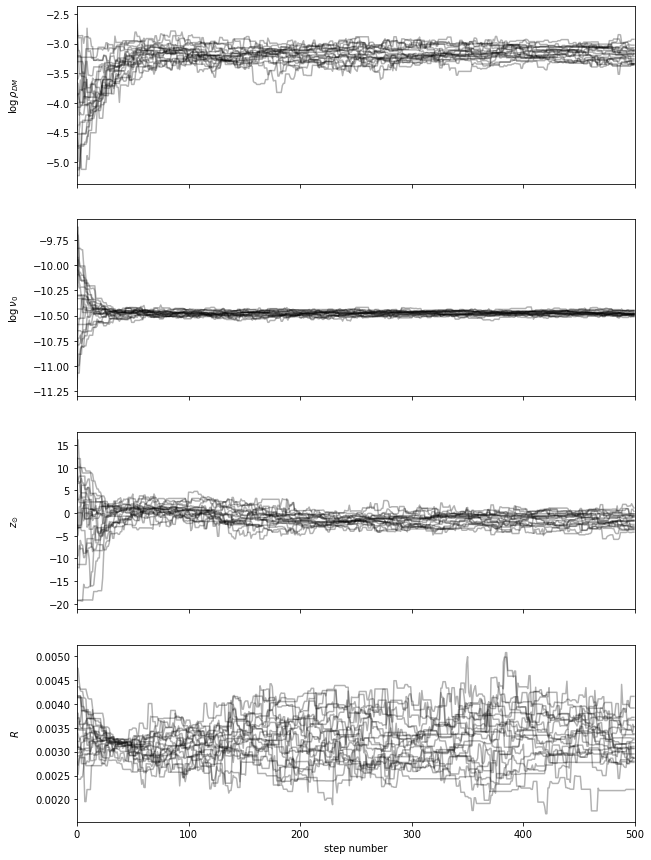

In [245]:
os.environ["OMP_NUM_THREADS"] = "16"
sampler_ = 0

labels = [r"$\log \rho_{DM}$",r"$\log \nu_0$" , r"$z_{\odot}$", r"$R$"]
data = (zdata, wdata)
with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, 
        ndim, 
        log_posterior_simple_DM, 
        args=[data, locs, scales, dim, norm_list_DM, uni_list_DM], 
        pool=pool
    )
    start = time.time()
    state = sampler.run_mcmc(p0, 500, progress=True)
    samples = sampler.get_chain()
    end = time.time()
    multi_time = end - start
    plot_chain(samples, labels, figsize=(10,15))
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    sampler_ = sampler

100%|██████████| 2000/2000 [02:40<00:00, 12.42it/s]


Multiprocessing took 161.1 seconds


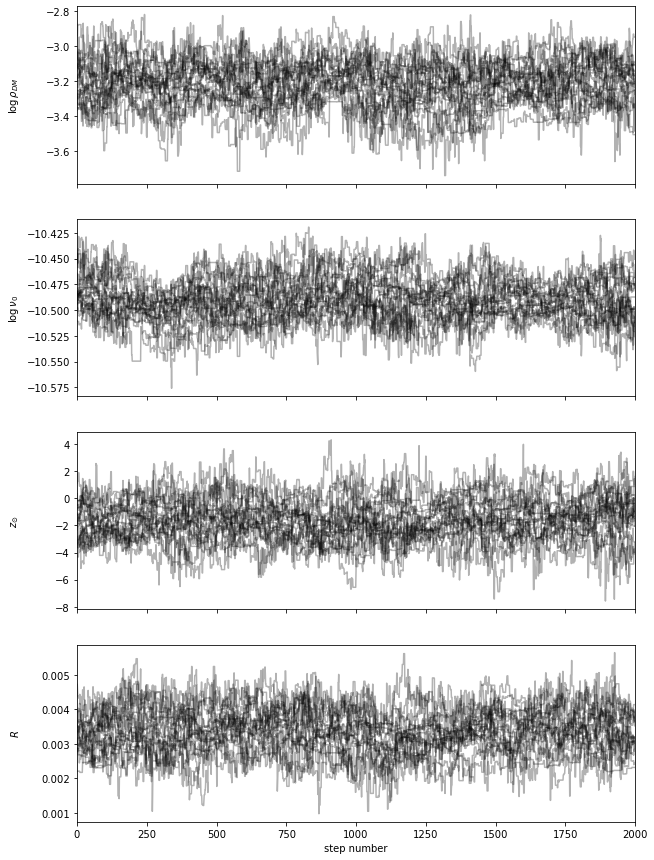

In [246]:
next_p0 = sampler_.get_chain()[-1]
with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, 
        ndim, 
        log_posterior_simple_DM, 
        args=[data, locs, scales, dim, norm_list_DM, uni_list_DM], 
        pool=pool
    )
    start = time.time()
    state = sampler.run_mcmc(next_p0, 2000, progress=True)
    samples = sampler.get_chain()
    end = time.time()
    multi_time = end - start
    plot_chain(samples, labels, figsize=(10,15))
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    sampler_ = sampler

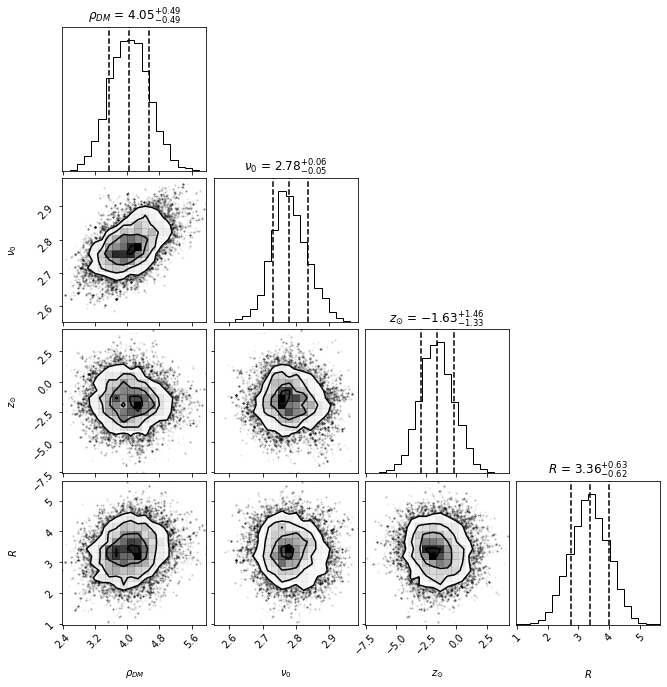

In [250]:
flat_samples = sampler_.get_chain(flat=True).copy()
flat_samples = flat_samples[:, :4]
flat_samples[:, 0] = np.exp(flat_samples[:, 0])/1E-2
flat_samples[:, 1] = np.exp(flat_samples[:, 1])/1E-5
flat_samples[:, 3] = flat_samples[:, 3]/1E-3


labels = [r"$\log \rho_{DM}$",r"$\log \nu_0$" , r"$z_{\odot}$", r"$R$"]

labels_2 = [r"$\rho_{DM}$",r"$\nu_0$" , r"$z_{\odot}$", r"$R$"]
fig = corner.corner(
    flat_samples, labels=labels_2,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True, title_kwargs={"fontsize": 12},
)

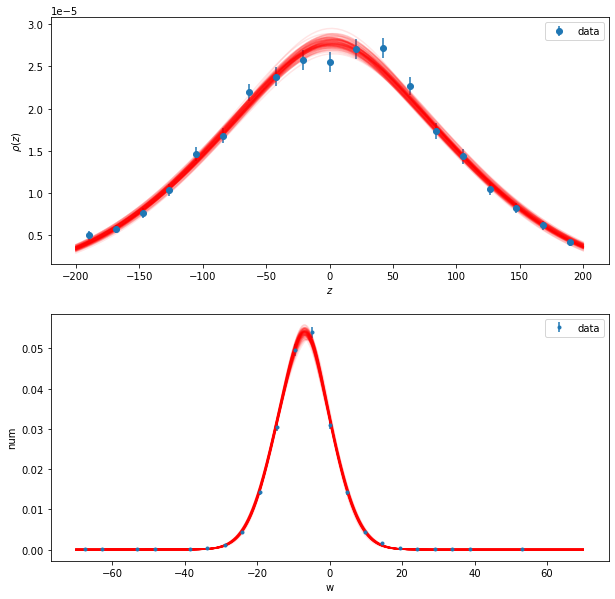

In [261]:
# plot two subplot
flat_samples = sampler_.get_chain(flat=True).copy()
alpha=0.1
zs = np.linspace(-200, 200, 100)
ws = np.linspace(-70, 70, 1000)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))
axes[0].errorbar(zmid, zdens, yerr=zerr, fmt='o', label='data')
axes[0].set_xlabel(r'$z$')
axes[0].set_ylabel(r'$\rho(z)$')
axes[0].legend()
axes[1].errorbar(wmid, wdens, yerr=werr, fmt='.', label='data')
axes[1].set_xlabel(r'w')
axes[1].set_ylabel(r'num')
axes[1].legend()
for i in range(100):
    index = np.random.randint(0, len(flat_samples))
    theta_dict = dict(
        rhos=rhos, 
        sigmaz=sigmaz, 
        rhoDM=np.exp(flat_samples[index, 0]),
        sigmaDD=0, 
        hDD=1, 
        nu0=np.exp(flat_samples[index, 1]),
        zsun=flat_samples[index, 2],
        R=flat_samples[index, 3],
        w0=flat_samples[index, 4:4+dim],
        sigma_w=np.exp(flat_samples[index, 4+dim:4+2*dim]),
        a=flat_samples[index, 4+2*dim:4+3*dim]
    )
    nu = nu_mod(zs, **theta_dict)
    axes[0].plot(zs, nu, label='model', c="r", alpha=alpha)
    Fw = fw(ws, **theta_dict)
    axes[1].plot(ws, Fw, label='model', c="r", alpha=alpha)
plt.show()

# All in one go

100%|██████████| 500/500 [00:41<00:00, 12.01it/s]


Multiprocessing took 41.8 seconds


100%|██████████| 2000/2000 [02:40<00:00, 12.45it/s]


Multiprocessing took 160.8 seconds


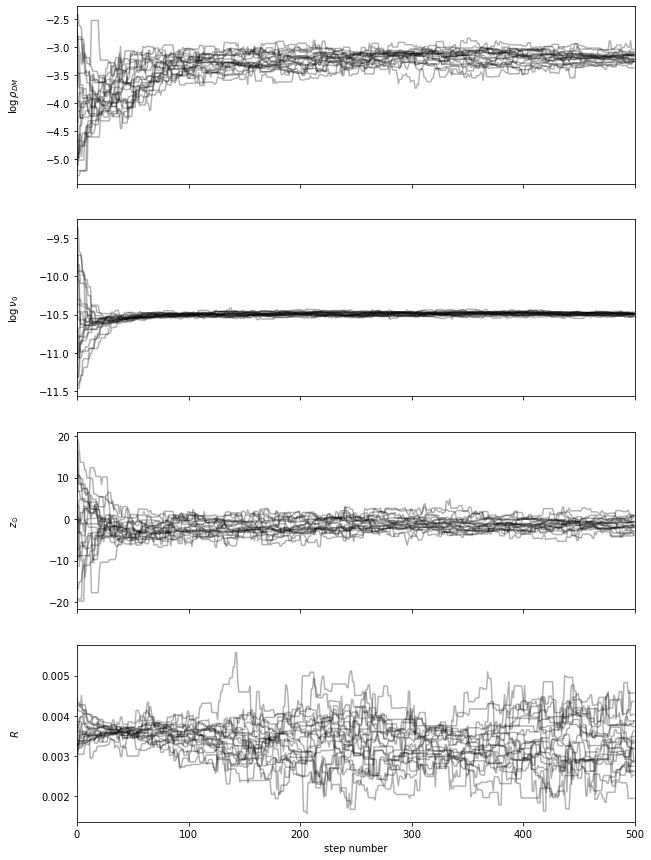

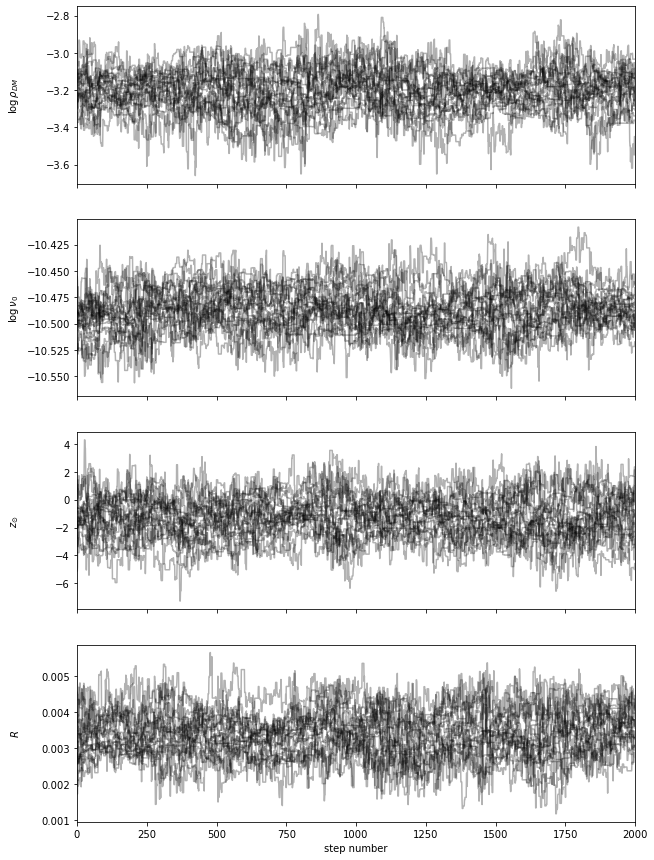

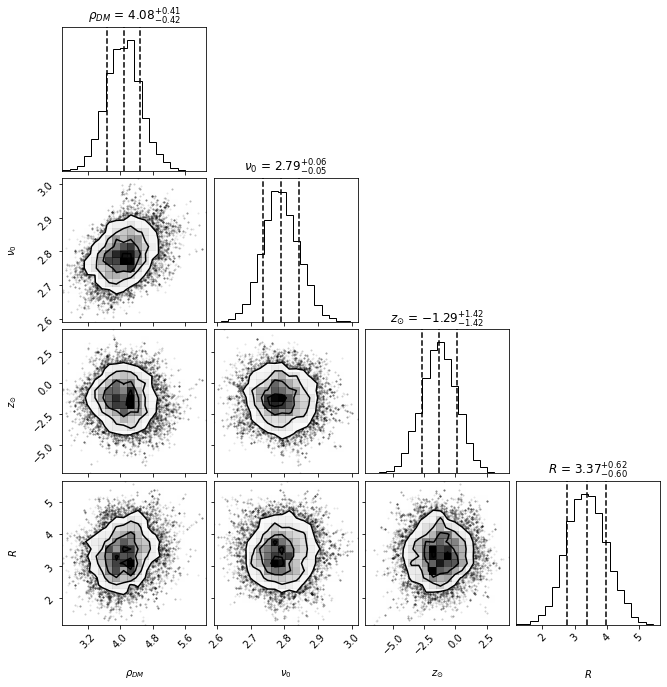

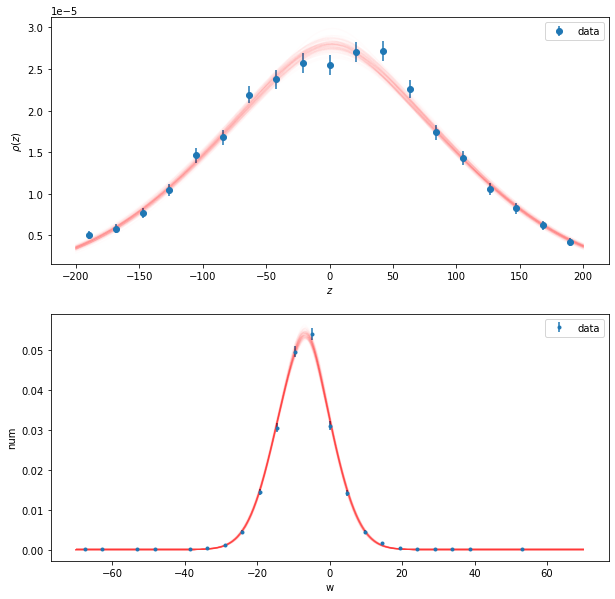

In [262]:
index = 0
df_number = vaex.open(number_files[index])
df_velocity = vaex.open(velocity_files[index])
df_popt = vaex.open(velocity_popt_files[index])
popt = df_popt['popt'].to_numpy()
wdens= df_velocity['wnum'].to_numpy()
werr = df_velocity['werr'].to_numpy()
wmid = df_velocity['w'].to_numpy()
dim = len(popt)//3

zdens = df_number['density_corr'].to_numpy()
zerr = df_number['density_err'].to_numpy()
zmid = df_number['z'].to_numpy()

# dm only

theta = [
    np.log(rhoDM), 
    np.log(4E-5), 
    10, 
    R, 
    w0, 
    np.log(sigma_w), 
    a_raw
]
# flatten the list
theta = np.concatenate([np.ravel(x) for x in theta])

locs = dict(
    log_rhoDM=np.log(0.005), 
    log_nu0=np.log(1E-5), 
    zsun=-20, 
    R=R, 
    w0=w0-5, 
    log_sigma_w=np.log(sigma_w*0.7), 
    a=np.select([a_raw > 0], [a_raw*0.7], default=a_raw*1.3)
)

scales = dict(
    log_rhoDM=np.log(0.1)-locs['log_rhoDM'], 
    log_nu0=np.log(1E-4)-locs['log_nu0'], 
    zsun=20-locs['zsun'], 
    R=0.6E-3, 
    w0=np.repeat(10, dim), 
    log_sigma_w=np.log(sigma_w*1.3)-locs['log_sigma_w'], 
    a=np.abs(a_raw*0.6)
)

uni_list_DM = ['log_rhoDM', 'log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a']
norm_list_DM = ['R']

zdata = (zmid, zdens, zerr)
wdata = (wmid, wdens, werr)

ndim = len(theta)
nwalkers = ndim*2+1
pars_list = uni_list+norm_list
index = 0

log_rhoDM_0 = np.random.uniform(low=locs['log_rhoDM'], high=locs['log_rhoDM']+scales['log_rhoDM'], size=nwalkers)
log_nu0_0 = np.random.uniform(low=locs['log_nu0'], high=locs['log_nu0']+scales['log_nu0'], size=nwalkers)
zsun_0 = np.random.uniform(low=locs['zsun'], high=locs['zsun']+scales['zsun'], size=nwalkers)
R_0 = np.random.normal(loc=locs['R'], scale=scales['R'], size=nwalkers)
w0_0 = np.random.uniform(low=locs['w0'], high=locs['w0']+scales['w0'], size=(nwalkers, dim))
log_sigma_w_0 = np.random.uniform(low=locs['log_sigma_w'], high=locs['log_sigma_w']+scales['log_sigma_w'], size=(nwalkers, dim))
a_0 = np.random.uniform(low=locs['a'], high=locs['a']+scales['a'], size=(nwalkers, dim))

p0 = np.array([log_rhoDM_0, log_nu0_0, zsun_0, R_0, *w0_0.T, *log_sigma_w_0.T, *a_0.T]).T

os.environ["OMP_NUM_THREADS"] = "16"
sampler_ = 0

labels = [r"$\log \rho_{DM}$",r"$\log \nu_0$" , r"$z_{\odot}$", r"$R$"]
data = (zdata, wdata)
with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, 
        ndim, 
        log_posterior_simple_DM, 
        args=[data, locs, scales, dim, norm_list_DM, uni_list_DM], 
        pool=pool
    )
    start = time.time()
    state = sampler.run_mcmc(p0, 500, progress=True)
    samples = sampler.get_chain()
    end = time.time()
    multi_time = end - start
    plot_chain(samples, labels, figsize=(10,15))
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    sampler_ = sampler

next_p0 = sampler_.get_chain()[-1]
with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, 
        ndim, 
        log_posterior_simple_DM, 
        args=[data, locs, scales, dim, norm_list_DM, uni_list_DM], 
        pool=pool
    )
    start = time.time()
    state = sampler.run_mcmc(next_p0, 2000, progress=True)
    samples = sampler.get_chain()
    end = time.time()
    multi_time = end - start
    plot_chain(samples, labels, figsize=(10,15))
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    sampler_ = sampler

flat_samples = sampler_.get_chain(flat=True).copy()
flat_samples = flat_samples[:, :4]
flat_samples[:, 0] = np.exp(flat_samples[:, 0])/1E-2
flat_samples[:, 1] = np.exp(flat_samples[:, 1])/1E-5
flat_samples[:, 3] = flat_samples[:, 3]/1E-3


labels = [r"$\log \rho_{DM}$",r"$\log \nu_0$" , r"$z_{\odot}$", r"$R$"]

labels_2 = [r"$\rho_{DM}$",r"$\nu_0$" , r"$z_{\odot}$", r"$R$"]
fig = corner.corner(
    flat_samples, labels=labels_2,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True, title_kwargs={"fontsize": 12},
)

# plot two subplot
flat_samples = sampler_.get_chain(flat=True).copy()
alpha=0.01
zs = np.linspace(-200, 200, 100)
ws = np.linspace(-70, 70, 1000)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))
axes[0].errorbar(zmid, zdens, yerr=zerr, fmt='o', label='data')
axes[0].set_xlabel(r'$z$')
axes[0].set_ylabel(r'$\rho(z)$')
axes[0].legend()
axes[1].errorbar(wmid, wdens, yerr=werr, fmt='.', label='data')
axes[1].set_xlabel(r'w')
axes[1].set_ylabel(r'num')
axes[1].legend()
for i in tqdm(range(300)):
    index = np.random.randint(0, len(flat_samples))
    theta_dict = dict(
        rhos=rhos, 
        sigmaz=sigmaz, 
        rhoDM=np.exp(flat_samples[index, 0]),
        sigmaDD=0, 
        hDD=1, 
        nu0=np.exp(flat_samples[index, 1]),
        zsun=flat_samples[index, 2],
        R=flat_samples[index, 3],
        w0=flat_samples[index, 4:4+dim],
        sigma_w=np.exp(flat_samples[index, 4+dim:4+2*dim]),
        a=flat_samples[index, 4+2*dim:4+3*dim]
    )
    nu = nu_mod(zs, **theta_dict)
    axes[0].plot(zs, nu, label='model', c="r", alpha=alpha)
    Fw = fw(ws, **theta_dict)
    axes[1].plot(ws, Fw, label='model', c="r", alpha=alpha)
plt.show()